Randomly generated Bernoulli bandit has reward probabilities:
 [0.765 0.122 0.99  0.065 0.864 0.351 0.475 0.12  0.789 0.85 ]
The best machine has index: 2 and proba: 0.9898525000530515


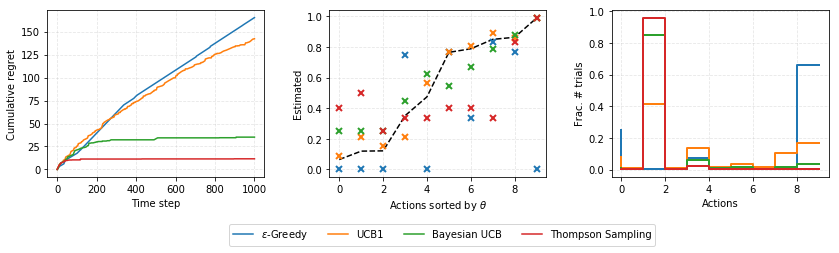

In [71]:
# whole program
%matplotlib inline  
import matplotlib  # noqa
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import time

class Bandit(object):

    def generate_reward(self, i):
        raise NotImplementedError
class BernoulliBandit(Bandit):

    def __init__(self, n, probas=None):
        assert probas is None or len(probas) == n
        self.n = n
        if probas is None:
            np.random.seed(int(time.time()))
            self.probas = [np.random.random() for _ in range(self.n)]
        else:
            self.probas = probas

        self.best_proba = max(self.probas)

    def generate_reward(self, i):
        # The player selected the i-th machine.
        if np.random.random() < self.probas[i]:
            return 1
        else:
            return 0

class Solver(object):
    def __init__(self, bandit):
        """
        bandit (Bandit): the target bandit to solve.
        """
        assert isinstance(bandit, BernoulliBandit)
        np.random.seed(int(time.time()))

        self.bandit = bandit

        self.counts = [0] * self.bandit.n
        self.actions = []  # A list of machine ids, 0 to bandit.n-1.
        self.regret = 0.  # Cumulative regret.
        self.regrets = [0.]  # History of cumulative regret.

    def update_regret(self, i):
        # i (int): index of the selected machine.
        self.regret += self.bandit.best_proba - self.bandit.probas[i]
        self.regrets.append(self.regret)

    @property
    def estimated_probas(self):
        raise NotImplementedError

    def run_one_step(self):
        """Return the machine index to take action on."""
        raise NotImplementedError

    def run(self, num_steps):
        assert self.bandit is not None
        for _ in range(num_steps):
            i = self.run_one_step()

            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)
class EpsilonGreedy(Solver):
    def __init__(self, bandit, eps, init_proba=1.0):
        """
        eps (float): the probability to explore at each time step.
        init_proba (float): default to be 1.0; optimistic initialization
        """
        super(EpsilonGreedy, self).__init__(bandit)

        assert 0. <= eps <= 1.0
        self.eps = eps

        self.estimates = [init_proba] * self.bandit.n  # Optimistic initialization

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        if np.random.random() < self.eps:
            # Let's do random exploration!
            i = np.random.randint(0, self.bandit.n)
        else:
            # Pick the best one.
            i = max(range(self.bandit.n), key=lambda x: self.estimates[x])

        r = self.bandit.generate_reward(i)
        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i
class UCB1(Solver):
    def __init__(self, bandit, init_proba=1.0):
        super(UCB1, self).__init__(bandit)
        self.t = 0
        self.estimates = [init_proba] * self.bandit.n

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        self.t += 1

        # Pick the best one with consideration of upper confidence bounds.
        i = max(range(self.bandit.n), key=lambda x: self.estimates[x] + np.sqrt(2 * np.log(self.t) / (1 + self.counts[x])))
        r = self.bandit.generate_reward(i)

        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i
class BayesianUCB(Solver):
    """Assuming Beta prior."""

    def __init__(self, bandit, c=3, init_a=1, init_b=1):
        """
        c (float): how many standard dev to consider as upper confidence bound.
        init_a (int): initial value of a in Beta(a, b).
        init_b (int): initial value of b in Beta(a, b).
        """
        super(BayesianUCB, self).__init__(bandit)
        self.c = c
        self._as = [init_a] * self.bandit.n
        self._bs = [init_b] * self.bandit.n

    @property
    def estimated_probas(self):
        return [self._as[i] / float(self._as[i] + self._bs[i]) for i in range(self.bandit.n)]

    def run_one_step(self):
        # Pick the best one with consideration of upper confidence bounds.
        i = max(
            range(self.bandit.n),
            key=lambda x: self._as[x] / float(self._as[x] + self._bs[x]) + beta.std(
                self._as[x], self._bs[x]) * self.c
        )
        r = self.bandit.generate_reward(i)

        # Update Gaussian posterior
        self._as[i] += r
        self._bs[i] += (1 - r)

        return i
class ThompsonSampling(Solver):
    def __init__(self, bandit, init_a=1, init_b=1):
        """
        init_a (int): initial value of a in Beta(a, b).
        init_b (int): initial value of b in Beta(a, b).
        """
        super(ThompsonSampling, self).__init__(bandit)

        self._as = [init_a] * self.bandit.n
        self._bs = [init_b] * self.bandit.n

    @property
    def estimated_probas(self):
        return [self._as[i] / (self._as[i] + self._bs[i]) for i in range(self.bandit.n)]

    def run_one_step(self):
        samples = [np.random.beta(self._as[x], self._bs[x]) for x in range(self.bandit.n)]
        i = max(range(self.bandit.n), key=lambda x: samples[x])
        r = self.bandit.generate_reward(i)

        self._as[i] += r
        self._bs[i] += (1 - r)

        return i 
        
def plot_results(solvers, solver_names, figname):
    """
    Plot the results by multi-armed bandit solvers.
    Args:
        solvers (list<Solver>): All of them should have been fitted.
        solver_names (list<str)
        figname (str)
    """
    assert len(solvers) == len(solver_names)
    assert all(map(lambda s: isinstance(s, Solver), solvers))
    assert all(map(lambda s: len(s.regrets) > 0, solvers))

    b = solvers[0].bandit

    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.3, wspace=0.3)

    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    # Sub.fig. 1: Regrets in time.
    for i, s in enumerate(solvers):
        ax1.plot(range(len(s.regrets)), s.regrets, label=solver_names[i])

    ax1.set_xlabel('Time step')
    ax1.set_ylabel('Cumulative regret')
    ax1.legend(loc=9, bbox_to_anchor=(1.82, -0.25), ncol=5)
    ax1.grid('k', ls='--', alpha=0.3)

    # Sub.fig. 2: Probabilities estimated by solvers.
    sorted_indices = sorted(range(b.n), key=lambda x: b.probas[x])
    ax2.plot(range(b.n), [b.probas[x] for x in sorted_indices], 'k--', markersize=12)
    for s in solvers:
        ax2.plot(range(b.n), [s.estimated_probas[x] for x in sorted_indices], 'x', markeredgewidth=2)
    ax2.set_xlabel('Actions sorted by ' + r'$\theta$')
    ax2.set_ylabel('Estimated')
    ax2.grid('k', ls='--', alpha=0.3)

    # Sub.fig. 3: Action counts
    for s in solvers:
        ax3.plot(range(b.n), np.array(s.counts) / float(len(solvers[0].regrets)), ls='steps', lw=2)
    ax3.set_xlabel('Actions')
    ax3.set_ylabel('Frac. # trials')
    ax3.grid('k', ls='--', alpha=0.3)
    plt.show()
def experiment(K, N):
    """
    Run a small experiment on solving a Bernoulli bandit with K slot machines,
    each with a randomly initialized reward probability.
    Args:
        K (int): number of slot machiens.
        N (int): number of time steps to try.
    """

    b = BernoulliBandit(K)
    print("Randomly generated Bernoulli bandit has reward probabilities:\n", np.around(b.probas,3))
    print("The best machine has index: {} and proba: {}".format(max(range(K), key=lambda i: b.probas[i]), max(b.probas)))

    test_solvers = [
        # EpsilonGreedy(b, 0),
        # EpsilonGreedy(b, 1),
        EpsilonGreedy(b, 0.01),
        UCB1(b),
        BayesianUCB(b, 3, 1, 1),
        ThompsonSampling(b, 1, 1)
    ]
    names = [
        # 'Full-exploitation',
        # 'Full-exploration',
        r'$\epsilon$' + '-Greedy',
        'UCB1',
        'Bayesian UCB',
        'Thompson Sampling'
    ]

    for s in test_solvers:
        s.run(N)

    plot_results(test_solvers, names, "results_K{}_N{}.png".format(K, N))

experiment(10, 1000)

In [29]:
temp = np.random.randn(4,3,3)
idx = np.arange(4)
np.random.shuffle(idx)
print(temp)
print(idx)
print('-----------')

[[[ 0.94427853 -1.26592666 -2.42432101]
  [ 0.97645216  1.1114906  -0.37262113]
  [ 0.1536329  -0.23263173  1.0977334 ]]

 [[ 0.20590404  0.41134552  0.23543306]
  [-0.76567263  0.92204993 -0.78356869]
  [ 0.77220094 -0.83419201  2.32476789]]

 [[-0.19663276  0.52741314 -0.71244539]
  [-1.12322379 -1.19229922  0.59939766]
  [ 1.83781318 -0.19514624  1.39188466]]

 [[ 0.15960085 -1.32340294  0.95808363]
  [-0.96527413  0.21107276 -1.10379716]
  [ 0.30067368 -0.48403368  0.95482625]]]
[3 2 1 0]
-----------


In [34]:
reverse_idx = [0,1,2,3]

print(temp)
print('-----------')
print(temp[idx])
print('-----------')
print(temp[idx][idx])
print('-----------')


[[[ 0.94427853 -1.26592666 -2.42432101]
  [ 0.97645216  1.1114906  -0.37262113]
  [ 0.1536329  -0.23263173  1.0977334 ]]

 [[ 0.20590404  0.41134552  0.23543306]
  [-0.76567263  0.92204993 -0.78356869]
  [ 0.77220094 -0.83419201  2.32476789]]

 [[-0.19663276  0.52741314 -0.71244539]
  [-1.12322379 -1.19229922  0.59939766]
  [ 1.83781318 -0.19514624  1.39188466]]

 [[ 0.15960085 -1.32340294  0.95808363]
  [-0.96527413  0.21107276 -1.10379716]
  [ 0.30067368 -0.48403368  0.95482625]]]
-----------
[[[ 0.15960085 -1.32340294  0.95808363]
  [-0.96527413  0.21107276 -1.10379716]
  [ 0.30067368 -0.48403368  0.95482625]]

 [[-0.19663276  0.52741314 -0.71244539]
  [-1.12322379 -1.19229922  0.59939766]
  [ 1.83781318 -0.19514624  1.39188466]]

 [[ 0.20590404  0.41134552  0.23543306]
  [-0.76567263  0.92204993 -0.78356869]
  [ 0.77220094 -0.83419201  2.32476789]]

 [[ 0.94427853 -1.26592666 -2.42432101]
  [ 0.97645216  1.1114906  -0.37262113]
  [ 0.1536329  -0.23263173  1.0977334 ]]]
-----------


In [35]:
import tensorflow as tf

In [57]:
sess = tf.InteractiveSession()

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [70]:
temp = tf.Variable(tf.random_normal((4,2,2)))
numbers = tf.Variable(np.array([3,2,1,0]))
ttemp  = tf.gather(temp,numbers)
tttemp = tf.gather(ttemp,numbers)

sess.run(tf.global_variables_initializer())
# tttemp = temp[numbers][numbers]

print(temp.eval())
print('----------')
print(ttemp.eval())
print('----------')
print(tttemp.eval())
print('----------')
print(tttemp.eval()==temp.eval())


[[[ 0.1181713   0.13662301]
  [-0.16900212 -0.53488225]]

 [[ 0.0798636   0.4478078 ]
  [ 1.8437486   0.521872  ]]

 [[-1.0198902   1.5149498 ]
  [-1.0840353   0.6434106 ]]

 [[-0.7653912  -0.2027399 ]
  [-0.48166198 -0.7388206 ]]]
----------
[[[-0.7653912  -0.2027399 ]
  [-0.48166198 -0.7388206 ]]

 [[-1.0198902   1.5149498 ]
  [-1.0840353   0.6434106 ]]

 [[ 0.0798636   0.4478078 ]
  [ 1.8437486   0.521872  ]]

 [[ 0.1181713   0.13662301]
  [-0.16900212 -0.53488225]]]
----------
[[[ 0.1181713   0.13662301]
  [-0.16900212 -0.53488225]]

 [[ 0.0798636   0.4478078 ]
  [ 1.8437486   0.521872  ]]

 [[-1.0198902   1.5149498 ]
  [-1.0840353   0.6434106 ]]

 [[-0.7653912  -0.2027399 ]
  [-0.48166198 -0.7388206 ]]]
----------
[[[ True  True]
  [ True  True]]

 [[ True  True]
  [ True  True]]

 [[ True  True]
  [ True  True]]

 [[ True  True]
  [ True  True]]]
